In [1]:
BATCH_SIZE = 4
EDGE_CROP = 16
NB_EPOCHS = 20
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'SIMPLE'
# downsampling inside the network
NET_SCALING = None
# downsampling in preprocessing
IMG_SCALING = (1, 1)
# number of validation images to use
VALID_IMG_COUNT = 4
# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 500
AUGMENT_BRIGHTNESS = False

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
import os
import gc; gc.enable() # memory is tight

In [3]:
ship_dir = '/mnt/deep_learning/'
train_image_dir = os.path.join(ship_dir, 'train_v2')
from skimage.morphology import label

In [4]:
from skimage.morphology import label
def multi_rle_encode(img):
    labels = label(img[:, :, 0])
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.int16)
    #if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)


In [5]:
masks = pd.read_csv(os.path.join(ship_dir,
                                 'train_ship_segmentations_v2.csv'))
print(masks.shape[0], 'masks found')
print(masks['ImageId'].value_counts().shape[0])
print(masks.head())

231723 masks found
192556
         ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [6]:
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])

In [7]:
masks.drop(['ships'], axis=1, inplace=True)
unique_img_ids.sample(5)

,ImageId,ships,has_ship,has_ship_vec
11555,0f4e4621b.jpg,0,0.0,[0.0]
138898,b885e1d34.jpg,0,0.0,[0.0]
46536,3e13f7e42.jpg,0,0.0,[0.0]
66566,58a564e31.jpg,0,0.0,[0.0]
34056,2d3d33fbf.jpg,0,0.0,[0.0]


In [8]:
from sklearn.model_selection import train_test_split
train_ids, valid_ids = train_test_split(unique_img_ids,
                 test_size = 0.3)
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

161844 training masks
69879 validation masks


In [9]:
train_df['grouped_ship_count'] = train_df['ships'].map(lambda x: (x + 1) // 2).clip(0, 7)

In [10]:
def sample_ships(in_df, base_rep_val=20000):
    if in_df['ships'].values[0] == 0:
        return in_df.sample(base_rep_val // 3)  # even more strongly undersample no ships
    else:
        return in_df.sample(base_rep_val, replace=(in_df.shape[0] < base_rep_val))

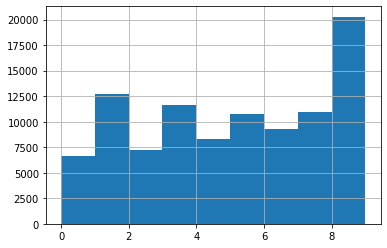

In [11]:
balanced_train_df = train_df.groupby('grouped_ship_count').apply(sample_ships)
balanced_train_df['ships'].hist(bins=np.arange(10))

In [12]:
def make_image_gen(in_df, batch_size = BATCH_SIZE):
    all_batches = list(in_df.groupby('ImageId'))
    out_rgb = []
    out_mask = []
    while True:
        np.random.shuffle(all_batches)
        for c_img_id, c_masks in all_batches:
            rgb_path = os.path.join(train_image_dir, c_img_id)
            c_img = imread(rgb_path)
            c_mask = masks_as_image(c_masks['EncodedPixels'].values)
            if IMG_SCALING is not None:
                c_img = c_img[::IMG_SCALING[0], ::IMG_SCALING[1]]
                c_mask = c_mask[::IMG_SCALING[0], ::IMG_SCALING[1]]
            out_rgb += [c_img]
            out_mask += [c_mask]
            if len(out_rgb)>=batch_size:
                yield np.stack(out_rgb, 0)/255.0, np.stack(out_mask, 0)
                out_rgb, out_mask=[], []

In [13]:
train_gen = make_image_gen(balanced_train_df)
train_x, train_y = next(train_gen)
print('x', train_x.shape, train_x.min(), train_x.max())
print('y', train_y.shape, train_y.min(), train_y.max())

x (4, 768, 768, 3) 0.0 1.0
y (4, 768, 768, 1) 0 1


In [14]:
valid_x, valid_y = next(make_image_gen(valid_df, VALID_IMG_COUNT))
print(valid_x.shape, valid_y.shape)

(4, 768, 768, 3) (4, 768, 768, 1)


In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
dg_args = dict(featurewise_center = False,
                  samplewise_center = False,
                  rotation_range = 15,
                  width_shift_range = 0.1,
                  height_shift_range = 0.1,
                  shear_range = 0.01,
                  zoom_range = [0.9, 1.25],
                  horizontal_flip = True,
                  vertical_flip = True,
                  fill_mode = 'reflect',
                   data_format = 'channels_last')

In [16]:
# brightness can be problematic since it seems to change the labels differently from the images
if AUGMENT_BRIGHTNESS:
    dg_args[' brightness_range'] = [0.5, 1.5]
image_gen = ImageDataGenerator(**dg_args)

if AUGMENT_BRIGHTNESS:
    dg_args.pop('brightness_range')
label_gen = ImageDataGenerator(**dg_args)

In [17]:
def create_aug_gen(in_gen, seed = None):
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    for in_x, in_y in in_gen:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        g_x = image_gen.flow(255*in_x,
                             batch_size = in_x.shape[0],
                             seed = seed,
                             shuffle=True)
        g_y = label_gen.flow(in_y,
                             batch_size = in_x.shape[0],
                             seed = seed,
                             shuffle=True)

        yield next(g_x)/255.0, next(g_y)

In [18]:
cur_gen = create_aug_gen(train_gen)
gc.collect()

25

In [19]:
t_x, t_y = next(cur_gen)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
# only keep first 9 samples to examine in detail
t_x = t_x[:9]
t_y = t_y[:9]

x (4, 768, 768, 3) float32 0.0 0.9957983
y (4, 768, 768, 1) float32 0.0 2.0


In [20]:
# Contruct a model using UNET with RESTNET 34
# import tensorflow as tf
# import segmentation_models as sm
# import tensorflow.keras.backend as K
# sm.set_framework('tf.keras')
# K.set_image_data_format('channels_last')
# model = sm.Unet('resnet34', classes=1, input_shape=(768,768,3), encoder_weights='imagenet')
# model.summary()

Using Theano backend.


Segmentation Models: using `keras` framework.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 768, 768, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 768, 768, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 774, 774, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 384, 384, 64) 9408        zero_padding2d[0][0]             
______________________________________________

In [107]:
# DeepLab_V3 plus with MobileNetV2 as backbone
from utils import *
SegClass = SegModel(ship_dir, (768, 768))
SegClass.set_batch_size(BATCH_SIZE)
backbone = 'mobilenetv2' #mobilenetv2, xception
NET = 'deeplab_' + backbone
n_classes = 1
better_model = False
load_pretrained_weights = False

model = SegClass.create_seg_model(net='original',n=n_classes, load_weights=load_pretrained_weights,
                                      multi_gpu=False, backbone=backbone)

print('Weights path:', SegClass.modelpath)
model.summary()

Weights path: /mnt/deep_learning//weights/mobilenetv2_original.h5
Model: "deeplabv3p"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 768, 768, 3) 0                                            
__________________________________________________________________________________________________
lambda_10 (Lambda)              (None, 768, 768, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 384, 384, 32) 864         lambda_10[0][0]                  
__________________________________________________________________________________________________
Conv_BN (BatchNormalization)    (None, 384, 384, 32) 128         Conv[0][0]                       
_______________________

In [108]:
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = tf.dtypes.cast(y_true_f, tf.float32) * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(tf.dtypes.cast(y_true_f, tf.float32)) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

In [109]:
from tensorflow.keras.losses import binary_crossentropy

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)
def dice_p_bce(in_gt, in_pred):
    return 1e-3*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)
def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)


In [110]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
weight_path="/mnt/deep_learning/weights/{}_weights.best.hdf5".format('seg_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1,
                             save_best_only=True, mode='max', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5,
                                   patience=3,
                                   verbose=1, mode='max', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_dice_coef",
                      mode="max",
                      patience=15) # probably needs to be more patient, but kaggle time is limited

In [111]:
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [112]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(1e-4, decay=1e-6), loss=bce_logdice_loss, metrics=[dice_coef, 'binary_accuracy', true_positive_rate])

In [113]:
import sys
oldStdout = sys.stdout
file = open('/mnt/deep_learning/logs/airbus_unet34_keras.out', 'w')
sys.stdout = file

  ...
    to  
  ['...']


In [114]:
step_count = min(MAX_TRAIN_STEPS, balanced_train_df.shape[0]//BATCH_SIZE)
aug_gen = create_aug_gen(make_image_gen(balanced_train_df))
loss_history = [model.fit_generator(aug_gen,
                            steps_per_epoch=step_count,
                            validation_data=(valid_x, valid_y),
                            epochs=NB_EPOCHS,
                            callbacks=callbacks_list,shuffle=True)]

In [115]:
sys.stdout = oldStdout

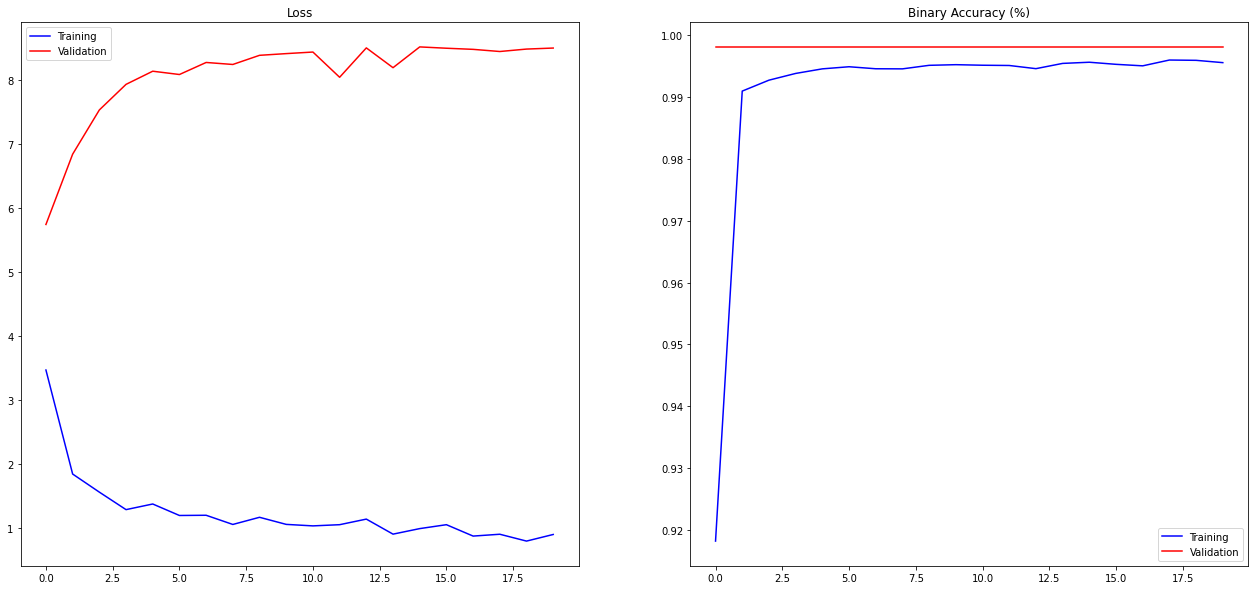

In [116]:
def show_loss(loss_history):
    epochs = np.concatenate([mh.epoch for mh in loss_history])
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 10))
    
    _ = ax1.plot(epochs, np.concatenate([mh.history['loss'] for mh in loss_history]), 'b-',
                 epochs, np.concatenate([mh.history['val_loss'] for mh in loss_history]), 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')
    
    _ = ax2.plot(epochs, np.concatenate([mh.history['binary_accuracy'] for mh in loss_history]), 'b-',
                 epochs, np.concatenate([mh.history['val_binary_accuracy'] for mh in loss_history]), 'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('Binary Accuracy (%)')

show_loss(loss_history)


In [118]:
model.load_weights(weight_path)
model.save('/mnt/deep_learning/weights/best_seg_model_2.h5')

TypeError: can't pickle _thread.RLock objects

9


Text(0.5, 1.0, 'Original Image')

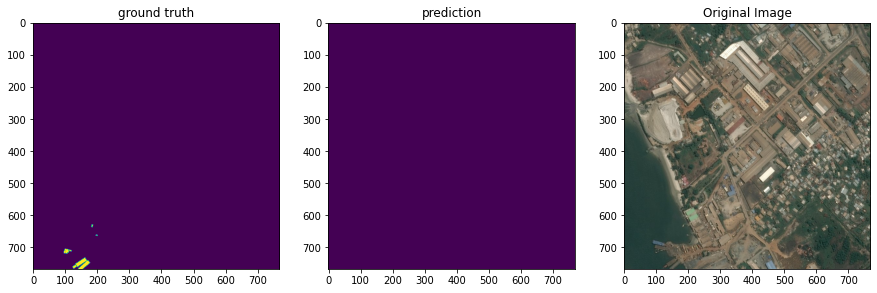

In [119]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5))
rle_0 = masks.query('ImageId=="00021ddc3.jpg"')['EncodedPixels'] # an efficient way to filter against pandas dataframe
print(len(rle_0))
img_0 = masks_as_image(rle_0)
ax1.imshow(img_0[:, :, 0])
ax1.set_title('ground truth')
ax2.imshow(reencoded)
ax2.set_title('prediction')
orig_img = plt.imread(os.path.join(train_image_dir, "00021ddc3.jpg"))
ax3.imshow(orig_img)
ax3.set_title('Original Image')

In [120]:
import os
ship_dir = '/mnt/deep_learning/'
test_image_dir = os.path.join(ship_dir, 'test_v2')

In [121]:
from matplotlib.cm import get_cmap
from skimage.morphology import binary_opening, disk, label

def masks_as_color(in_mask_list):
    # Take the individual ship masks and create a color mask array for each ships
    all_masks = np.zeros((768, 768), dtype = np.float)
    scale = lambda x: (len(in_mask_list)+x+1) / (len(in_mask_list)*2) ## scale the heatmap image to shift 
    for i,mask in enumerate(in_mask_list):
        if isinstance(mask, str):
            all_masks[:,:] += scale(i) * rle_decode(mask)
    return all_masks

def raw_prediction(img, path=test_image_dir):
    c_img = imread(os.path.join(path, img))
    c_img = np.expand_dims(c_img, 0)/255.0
    cur_seg = model.predict(c_img)[0]
    return cur_seg, c_img[0]

def smooth(cur_seg):
    return binary_opening(cur_seg>0.99, np.expand_dims(disk(2), -1))

def predict(img, path=test_image_dir):
    cur_seg, c_img = raw_prediction(img, path=path)
    return smooth(cur_seg), c_img

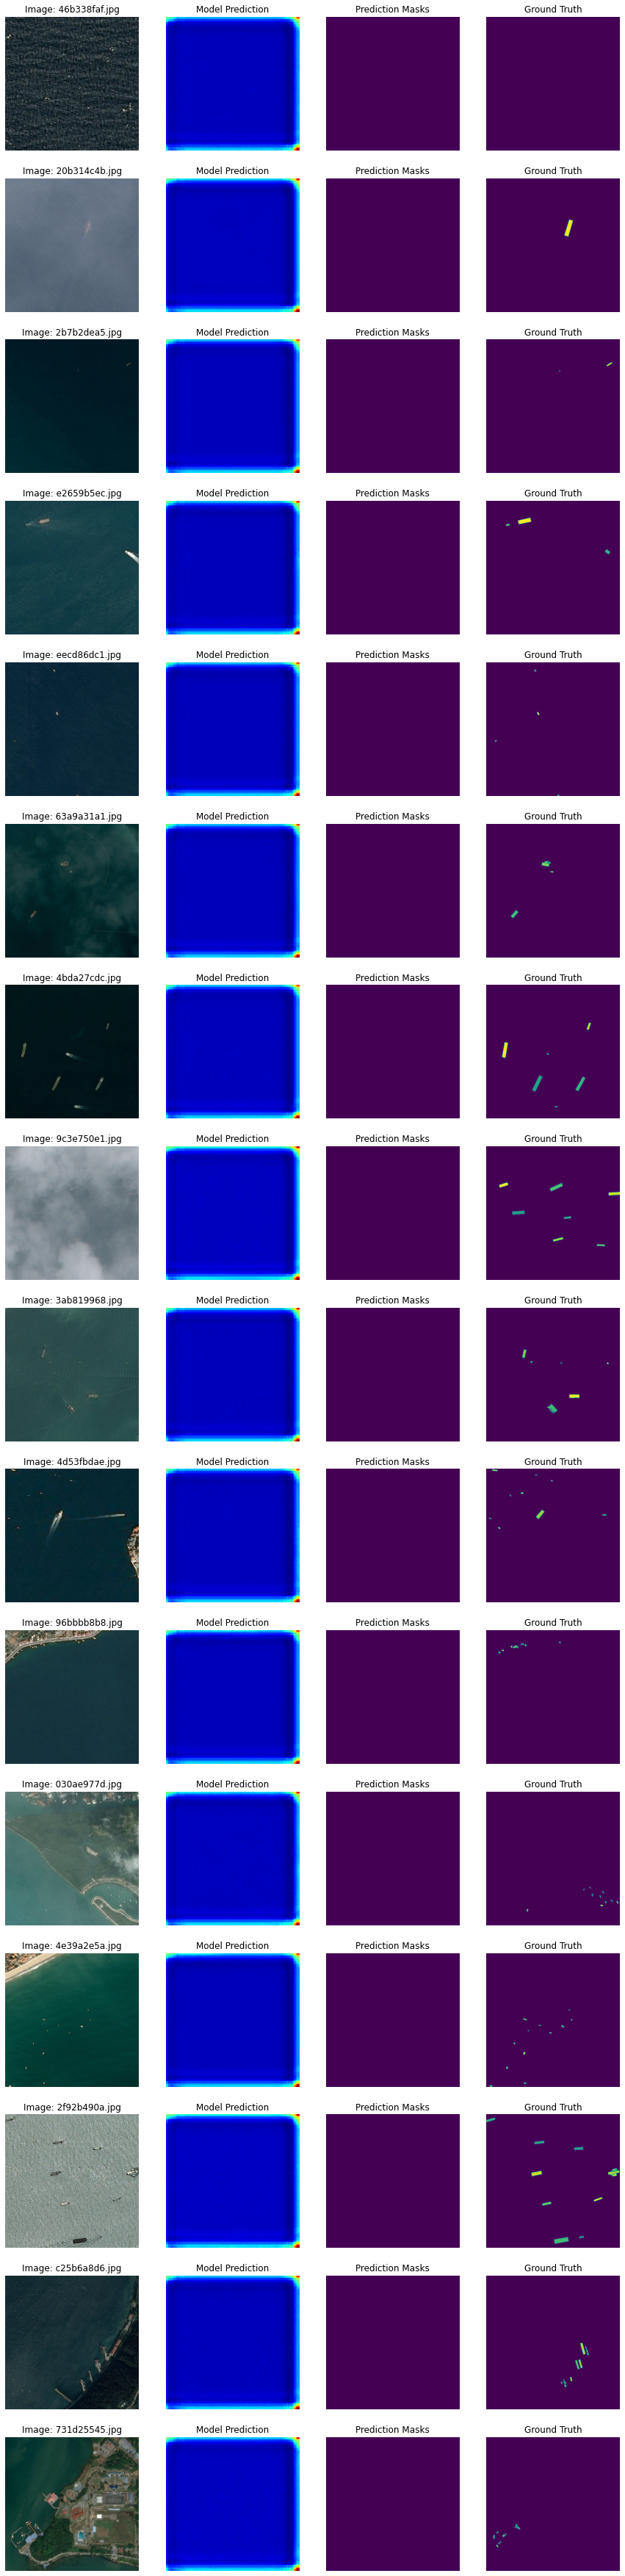

In [122]:
## Get a sample of each group of ship count
samples = valid_df.groupby('ships').apply(lambda x: x.sample(1))
fig, m_axs = plt.subplots(samples.shape[0], 4, figsize = (15, samples.shape[0]*4))
[c_ax.axis('off') for c_ax in m_axs.flatten()]

for (ax1, ax2, ax3, ax4), c_img_name in zip(m_axs, samples.ImageId.values):
    first_seg, first_img = raw_prediction(c_img_name, train_image_dir)
    ax1.imshow(first_img)
    ax1.set_title('Image: ' + c_img_name)
    ax2.imshow(first_seg[:, :, 0], cmap=get_cmap('jet'))
    ax2.set_title('Model Prediction')
    smoothened_img = smooth(first_seg)
    reencoded = masks_as_color(multi_rle_encode(smoothened_img))
    ax3.imshow(reencoded)
    ax3.set_title('Prediction Masks')
    ground_truth = masks_as_color(masks.query('ImageId=="{}"'.format(c_img_name))['EncodedPixels'])
    ax4.imshow(ground_truth)
    ax4.set_title('Ground Truth')
    
fig.savefig('validation.png')

In [123]:
import os
test_image_files = os.listdir(test_image_dir)

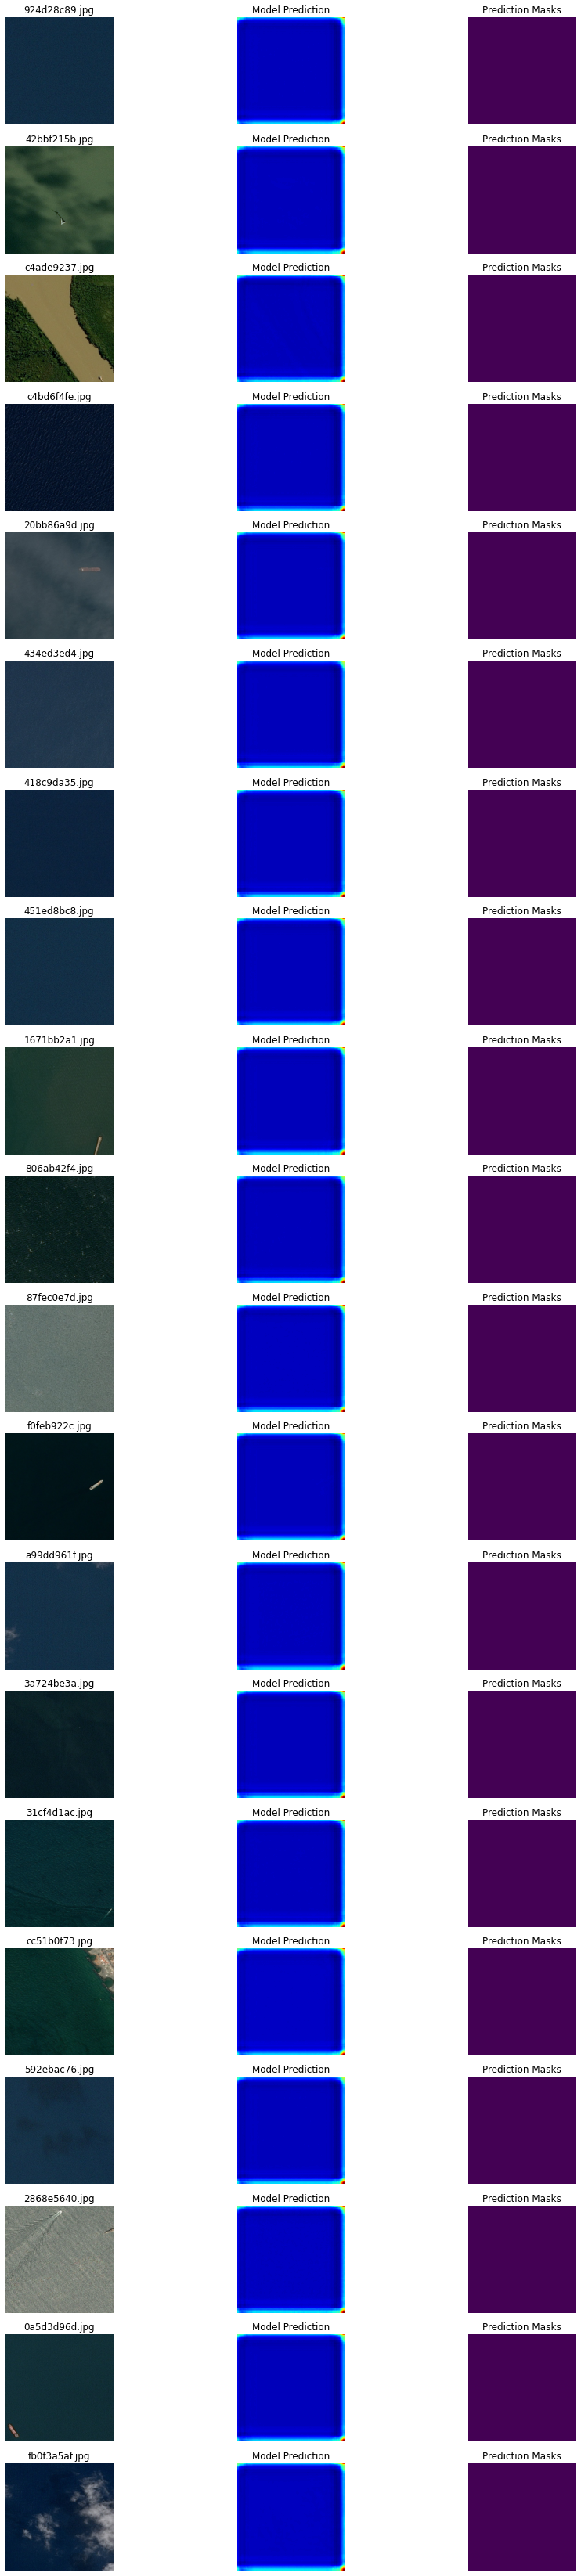

In [124]:
test_images_count = 20
fig, m_axs = plt.subplots(len(test_image_files[:test_images_count]), 3, figsize = (15, test_images_count*3))
[c_ax.axis('off') for c_ax in m_axs.flatten()]

for (ax1, ax2, ax3), c_img_name in zip(m_axs, test_image_files[:test_images_count]):
    first_seg, first_img = raw_prediction(c_img_name, test_image_dir)
    ax1.imshow(first_img)
    ax1.set_title(c_img_name)
    ax2.imshow(first_seg[:, :, 0], cmap=get_cmap('jet'))
    ax2.set_title('Model Prediction')
    smoothened_img = smooth(first_seg)
    reencoded = masks_as_color(multi_rle_encode(smoothened_img))
    ax3.imshow(reencoded)
    ax3.set_title('Prediction Masks')